# Introduction to Machine Learning 

### Final Project | Pankti Shah | Novemeber 14, 2021 

### Canadian Produced Cheese Data Prediction 


____________________________________________________________________________________________________________________________________________

# Introduction 

Purpose

A comprehensive database dedicated solely to Canadian cheeses made from cow, goat, sheep, or buffalo milk is being analyzed. Canada produces more than 1450 cheeses that are listed in the Canadian Cheese Directory. The several varieties of cheese have been established according to guidelines including the type of milk, the cheese category, the milk treatment, the fat content, the ripening period and the production method.

Based on various features, models will be developed to predict whether cheese can be classified as low fat or high fat cheese. 

Milk fat is about 70% saturated fat, 25% monounsaturated, and 5% polyunsaturated. Because a high intake of saturated fat can increase LDL cholesterol levels, and because cheese is often high in sodium, it is generally recommended to eat cheese in limited amounts as its components may exert a negative health effect. Switching from full fat dairy products to low fat reduces energy intake, thereby preventing weight gain as well as reducing saturated fat intake. In general, there are health benefits of predicting whether cheese formulation will be high fat or low fat, which will help with new cheese production, analyze sales data. In addition, some food require low fat cheese vs high fat, so for consumer it would be important to be able to predict this and for producer to know whether formulation of cheese make will be low fat or high fat. 

Predicting high or low fat content of cheese is a classification machine learning problem. Positive label of the data is being described as cheese that is categorize as 'high fat level'. 

# Exploratory Data Analysis (8 pts)

In [51]:
#import relevant libraries 

# Import libraries needed for this lab
from hashlib import sha1

import altair as alt
import graphviz
import numpy as np
import pandas as pd
import string
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    StandardScaler,
    normalize,
    scale)
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from scipy.stats import lognorm, loguniform, randint

#alt.renderers.enable('mimetype')
alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('default')

In [11]:
# Read in the data.
cheese_df = pd.read_csv('data/cheese_data.csv')
print('Table 1: Data from the Canadian Cheese Directory')
cheese_df.head()

Table 1: Data from the Canadian Cheese Directory


,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
0,228,NB,Farmstead,47.0,"Sharp, lactic",Uncooked,0,Firm Cheese,Ewe,Raw Milk,Washed Rind,Sieur de Duplessis (Le),lower fat
1,242,NB,Farmstead,47.9,"Sharp, lactic, lightly caramelized",Uncooked,0,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Tomme Le Champ Doré,lower fat
2,301,ON,Industrial,54.0,"Mild, tangy, and fruity","Pressed and cooked cheese, pasta filata, inter...",0,Firm Cheese,Cow,Pasteurized,NaN,Provolone Sette Fette (Tre-Stelle),lower fat
3,303,NB,Farmstead,47.0,Sharp with fruity notes and a hint of wild honey,NaN,0,Veined Cheeses,Cow,Raw Milk,NaN,Geai Bleu (Le),lower fat
4,319,NB,Farmstead,49.4,Softer taste,NaN,1,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Gamin (Le),lower fat


In [3]:
cheese_df.shape

(1042, 13)

This datatable has 1042 rows. Various information is included as describe under each columns. Following columns will be removed as they are irrelevant and will not contribute to the analysis: CheeseID, FlavourEn, CharacteristicsEn, RindTypeEn, CheeseName. ManufacturerProCode is used because there might be some relationship between MilkType and ManufacturingType in particular province with types of cheese they are able to manufacture. 'Moisuture Percent' is an important feature to healp cateogrize 'Cheese Type'. 'Organic' feature is included as it might influence degree of fat content in the cheese (ie., organic milk inherently might have higher fat level than non organic milk). 

In [12]:
#drop columns that are not relvant
cheese_dfs = cheese_df.drop(columns=['CheeseId','FlavourEn','CharacteristicsEn','RindTypeEn','CheeseName'])
print('Table 2: Categories from the Canadian Cheese Directory that will be used in analysis')
cheese_dfs.head()

Table 2: Categories from the Canadian Cheese Directory that will be used in analysis


,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,FatLevel
0,NB,Farmstead,47.0,0,Firm Cheese,Ewe,Raw Milk,lower fat
1,NB,Farmstead,47.9,0,Semi-soft Cheese,Cow,Raw Milk,lower fat
2,ON,Industrial,54.0,0,Firm Cheese,Cow,Pasteurized,lower fat
3,NB,Farmstead,47.0,0,Veined Cheeses,Cow,Raw Milk,lower fat
4,NB,Farmstead,49.4,1,Semi-soft Cheese,Cow,Raw Milk,lower fat


Included details about different features being used, and explained why certain columns may or may not have been dropped/included.

Various features will be used for developing models and predicting 'Fat Level' of cheese. Following 


In [13]:
cheese_dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ManufacturerProvCode  1042 non-null   object 
 1   ManufacturingTypeEn   1042 non-null   object 
 2   MoisturePercent       1028 non-null   float64
 3   Organic               1042 non-null   int64  
 4   CategoryTypeEn        1019 non-null   object 
 5   MilkTypeEn            1041 non-null   object 
 6   MilkTreatmentTypeEn   977 non-null    object 
 7   FatLevel              1042 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 65.2+ KB


In [14]:
print('Table 3: General Statistics for Data from the Canadian Cheese Directory')
cheese_dfs.describe(include='all')

Table 3: General Statistics for Data from the Canadian Cheese Directory


,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,FatLevel
count,1042,1042,1028.000000,1042.000000,1019,1041,977,1042
unique,10,3,NaN,NaN,6,8,3,2
top,QC,Industrial,NaN,NaN,Firm Cheese,Cow,Pasteurized,lower fat
freq,796,455,NaN,NaN,349,743,800,684
mean,NaN,NaN,47.069747,0.095010,NaN,NaN,NaN,NaN
std,NaN,NaN,9.592647,0.293369,NaN,NaN,NaN,NaN
min,NaN,NaN,12.000000,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,40.000000,0.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,46.000000,0.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,52.000000,0.000000,NaN,NaN,NaN,NaN


In [7]:
# Visualization that contribute to describing the data 
plot1 = alt.Chart(cheese_dfs).mark_boxplot().encode(
x = alt.X('MilkTreatmentTypeEn', title='Type of Milk Treatment'),
y = alt.Y('MoisturePercent', title = ' Cheese Moisure percent'), 
color = alt.Color('FatLevel', title = 'Fat Level')).properties(width=400, height=500, title='Plot 1: Moisture content on different milk treatment').facet('FatLevel')

print('Plot 1: Moisture content on different milk treatment')
plot1

Plot 1: Moisture content on different milk treatment


alt.FacetChart(...)

Plot 1 shows that lower fat cheese tends to have on average higher cheese moisture content. However, variability in the data is greatest for the cheese that is pasteurized. 

In [8]:
plot2 = alt.Chart(cheese_dfs).mark_boxplot().encode(
x = alt.X('CategoryTypeEn', title = 'Type of Cheese Category'),
y = alt.Y('MoisturePercent', title='Cheese Moisure percent', sort='-x'),
color = alt.Color('FatLevel')).properties(width=400, height=500, title='Plot 2: Moisture content on different cheese category').facet('FatLevel')

print('Plot 2: Moisture content on different cheese category')

plot2

Plot 2: Moisture content on different cheese category


alt.FacetChart(...)

Plot 2 shows that each cheese category have similar moisture content, whether it is being labeled as high or low fat cheese. Moisture content varies across different types of cheese categories. Fresh cheese typically has the highest moisture content, while hard cheese has the lowest moisture content. 

In [9]:
plot3 = alt.Chart(cheese_dfs).mark_bar().encode(
x = alt.X('MilkTypeEn', title='Milk Type'),
y = alt.Y('count(FatLevel)',sort='x', title = 'Cheese Category'),
color = alt.Color('FatLevel')).properties(width=400, height=500, title='Plot 3: Number of cheese production for various type of Milk ').facet('FatLevel')

print('Plot 3: Number of cheese production for various type of Milk')

plot3

Plot 3: Number of cheese production for various type of Milk


alt.FacetChart(...)

Plot 3 shows that Canadian cheese is mostly coming from cow, Ew and Goat, respectively. From our dataset, we have greatest number of cheese that is being identified as lower fat, and being produced from cows. 

From .info() from above, we see several cateogies have missing values in the database. We will be imputing float and object types using the strategy 'most_frequent' as that is the only option available for imputing non-numeric data. We will not get rid of null rows, otherwise we will lose significant data. 

In [65]:
# define x, y
# Split the data into the necessary train and test splits. 
x = cheese_dfs.drop(columns = 'FatLevel')
y = cheese_dfs['FatLevel']
X_train, X_test, y_train, y_test = train_test_split (x,y,test_size = 0.2, random_state=7)

# Impute null values. Means inventing values for the missing data
imputer = SimpleImputer(strategy = 'most_frequent')
imputer.fit(X_train)
X_train_imp = imputer.transform(X_train)
X_test_imp = imputer.transform(X_test)

# Transform X_train_imp into a dataframe using the column and index labels from X_train
X_train_imp_df = pd.DataFrame(X_train_imp, columns=X_train.columns, index=X_train.index)
X_test_imp_df = pd.DataFrame(X_test_imp, columns=X_test.columns, index=X_test.index)
y_train_df = pd.DataFrame(y_train, index=y_train.index)
y_test_df = pd.DataFrame(y_test, index=y_test.index)

In [66]:
print('Table 4: Training Data from the Canadian Cheese Directory after imputation')
X_train_imp_df.head()

Table 4: Training Data from the Canadian Cheese Directory after imputation


,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn
680,QC,Industrial,39.0,0,Firm Cheese,Cow,Pasteurized
1013,QC,Farmstead,46.0,0,Semi-soft Cheese,Cow,Pasteurized
1025,QC,Industrial,43.0,1,Firm Cheese,Cow,Thermised
802,QC,Artisan,34.0,0,Firm Cheese,Cow,Raw Milk
754,ON,Industrial,52.0,0,Soft Cheese,Cow,Pasteurized


In [67]:
print('Table 5: Statistics for Training Data from the Canadian Cheese Directory after imputation')
X_train_imp_df.describe(include='all')

Table 5: Statistics for Training Data from the Canadian Cheese Directory after imputation


,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn
count,833,833,833.0,833,833,833,833
unique,10,3,60.0,2,6,8,3
top,QC,Industrial,50.0,0,Firm Cheese,Cow,Pasteurized
freq,633,373,137.0,755,291,595,697


In our training data set, we see that 10 Canadian provinces are manufacturer for Cheese, with 3 manufacturing type that produce a wide range of cheese with moisutre content. Cheese are either categorize as organic or inorganic. Cheese are made up of from one of 8 different types of milks, and treated 3 different ways. Cheese are also cateogizes into one of six categories. Most popular manufacturer is Industrial from Quebec. Most popular cheese is inorganic, firm cheese from cow milk. Pasteurized milk and cheese with 50% moisture is also the top most popular type of cheese from our training data. 

In [68]:
# Determining Imabalance in Data Training
y_train.value_counts()

lower fat     549
higher fat    284
Name: FatLevel, dtype: int64

A class imbalance typically refers to having more examples of one class than another in trianing set. Here, we have many more lower fat example than hgher fat, therefore we do have a degree of imbalance. Higher fat cheese isn't neccessary more rare nor data collection methods have changed.As a result, it would be alright to leave the class imbalanced; however, I will resolve the imbalance later when creating models by using 'balanced' weight_class parameter. 


# Methods & Results


In [69]:
# Baseline model

dummy_class = DummyClassifier(strategy='stratified',random_state=123)
dummy_class.fit(X_train_imp,y_train)
dummy_class.predict(X_test_imp)
dummy_score_train = dummy_class.score(X_train_imp,y_train)
dummy_score_test = dummy_class.score(X_test_imp,y_test)


print('Train score: ', dummy_score_train)
print('Test score: ', dummy_score_test)

Train score:  0.5474189675870348
Test score:  0.5358851674641149


In [70]:
# Identify different feature type and explain transformation that needs to be applied to each

#Split the numeric and categorical features
numeric_features = ['MoisturePercent']
categorical_features = ['ManufacturerProvCode','ManufacturingTypeEn','CategoryTypeEn','MilkTypeEn','MilkTreatmentTypeEn']
binary_features = ['Organic']

#Transformations required: Imputer, Scaler 
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

binary_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(drop="if_binary", dtype=int)
    )

# Column transformer
# Transform the data (Scaling, one-hot encoding (dropping a column if binary), ordinal encoding, etc).
preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        (binary_transformer, binary_features)
)


In [71]:
# Use pipelines and column transformers when needed. 
# Algorithm 1: KNeighborsClassifier
main_pipe_KNeighboursClassifier = make_pipeline(preprocessor, KNeighborsClassifier())

# Cross validate algorith 1 - KNeighborsClassifier
KNeighborsClassifier_scores = pd.DataFrame(cross_validate(main_pipe_KNeighboursClassifier, X_train_imp_df, y_train, return_train_score = True))
print('KNeighborsClassifier_scores:\n', KNeighborsClassifier_scores.mean())

KNeighborsClassifier_scores:
 fit_time       0.021414
score_time     0.021038
test_score     0.810324
train_score    0.866147
dtype: float64


In [72]:
# Algorithm 2: DecisionTreeClassifier
main_pipe_DecisionTreeClassifier = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=2))

# Cross validate algorith 2 - DecisionTreeClassifier
DecisionsClassifier_scores = pd.DataFrame(cross_validate(main_pipe_DecisionTreeClassifier, X_train_imp_df, y_train, return_train_score = True))
print('DecisionTreeClassifier:\n', DecisionsClassifier_scores.mean())

DecisionTreeClassifier:
 fit_time       0.024977
score_time     0.011133
test_score     0.815150
train_score    0.947782
dtype: float64


Since the data is imbalanced, class_weight argument will be used to balance the data.

In [73]:
# Algorithm 3: SVC
main_pipe_SVC = make_pipeline(preprocessor, SVC(class_weight ='balanced', random_state=2020))

#cross validate algorith 3
SVC_scores = pd.DataFrame(cross_validate(main_pipe_SVC, X_train_imp_df, y_train, return_train_score=True)) 
print('SVC:\n', SVC_scores.mean())

SVC:
 fit_time       0.042239
score_time     0.014116
test_score     0.789907
train_score    0.822030
dtype: float64


Taking the SVC model from the step above,  and using RandomizedSearchCV to hyperparameter tune the estimator. 

In [74]:
# Alogirthm3
param_grid = {
    "svc__gamma": [0.1, 1.0, 10, 100],
    "svc__C": [0.1, 1.0, 10, 100, 150]
}

ran_search = RandomizedSearchCV(main_pipe_SVC,param_grid,n_jobs=-1,cv=5,return_train_score=True,n_iter=10, random_state=2020)
ran_search.fit(X_train_imp_df,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['MoisturePercent']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
                                 

In [75]:
# Scoring Hyperparameter Tuning 

# Using best performing model, socre your model on the test set
ran_search.score(X_train_imp_df, y_train)
optimal_parameters = ran_search.best_params_
print('optimal parameters: ', optimal_parameters)
optimal_score = ran_search.best_score_
print('optimal score: ', optimal_score)
best_model = ran_search.best_estimator_
print('Best Estimator: ', best_model)

training_score = best_model.score(X_train_imp_df, y_train)
print('Best Training Score: ', training_score)

test_score = best_model.score(X_test_imp_df, y_test)
print('Best Test Score: ', test_score)


optimal parameters:  {'svc__gamma': 0.1, 'svc__C': 100}
optimal score:  0.7863213332371402
Best Estimator:  Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['MoisturePercent']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                  

Plot 4: Confusion Matrix Plot from RandomizedSearchCV Model


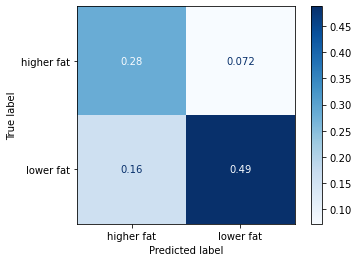

In [76]:
#using best performing model, socre your model on the test set
print('Plot 4: Confusion Matrix Plot from RandomizedSearchCV Model')
plot_confusion_matrix(ran_search,X_test_imp_df,y_test,normalize='all',cmap='Blues')

It correctly predicted higher fat label as higher fat, 28%, and lower fat cheese as lower fat 49% of the time. It incorrently predicts higher fat cheese as lower fat only 7.2% of the time, and lower fat as higher fat cheese 16% of the time. 

In [77]:
# Show the confusion matrix and classification report from your test set predictions.
print('Table 6: Classification Report from RandomizedSearchCV Model')
print(classification_report(y_test,ran_search.predict(X_test_imp_df)))

Table 6: Classification Report from RandomizedSearchCV Model
              precision    recall  f1-score   support

  higher fat       0.64      0.80      0.71        74
   lower fat       0.87      0.76      0.81       135

    accuracy                           0.77       209
   macro avg       0.76      0.78      0.76       209
weighted avg       0.79      0.77      0.77       209



In [78]:
training_score = best_model.score(X_train_imp_df, y_train)
print('Best Training Score: ', training_score)

test_score = best_model.score(X_test_imp_df, y_test)
print('Best Test Score: ', test_score)

Best Training Score:  0.8751500600240096
Best Test Score:  0.7703349282296651


Above we are comparing various different types of scoring methods on our model. Best training scope is 0.875, and test score is 0.77. The model is overpredicting. 
Then, when taking a look at other scoring metrics from the classification report, recall performance better, however f-1 score is close. Overall, model's predictive capabilities are stronger for lower fat cheese prediction than higher fat cheese. This is evident from the results we see in the confusion plot, where we are predicting lower fat cheese better. 

# Discussion 

## Summarized and reported the final test scores and metrics. Results discussion

Following models were developed with their respective training and testing results.
1. Dummy Classifier 
test_score     0.535
train_score    0.547

2. KNeighborsClassifier_scores:
test_score     0.810
train_score    0.866

3. DecisionTreeClassifier:
test_score     0.815
train_score    0.948

4. SVC Model
test_score     0.790
train_score    0.822

Based on training and testing data, SVC model was concluded to be better with the least degree of overfitting. Then, hyperperamater were optimized using RandomGridSearchMethod. The best estimator for SVC were found to be gamma=0.1, and C=100. Best training and testing score from the best model were found to be: 
Best Training Score:  0.875
Best Test Score:  0.77

Confusion matrix and classification reports were ran as well. Weighted average metrics for precision, recall and F-1 scores were found to be similar at 0.79, 0.77, 0.77, respectively. It correctly predicted higher fat labels 28% of the time, and lower fat cheese labels 49% of the time. It incorrently predicts higher fat cheese as lower fat only 7.2% of the time, and lower fat as higher fat cheese 16% of the time. Overall, model works better for predicting lower fat label than higher fat label. 

### Compared the model's results to the baseline model
Our baseline model, Dummy Classifier, had quite a poor test and train score, compared to the hyper-parameter tuned SVC model. Training score for optimized model was 0.88 versus 0.55 for the dummy classifier model. Testing score for the optimized model was 0.77, compared to of the dummy classifier at 0.54. 

### Future opportunities for improvement in the performance/interpretability. 
Obtaining larger data set, that were inherently more balanced, and had less missing value would have produced better results. In addition, other models seach as GridSearchCV could have been ran to compare results with RandomSearchCV, perhaps that would have had better model performance.

### Final Concluding Remarks

A comprehensive database dedicated solely to Canadian cheeses made from cow, goat, sheep, or buffalo milk were analyzed. Canada produces more than 1450 cheeses that are listed in the Canadian Cheese Directory. Based on various features, various models were developed to predict whether cheese can be classified as low or high fat cheese. Predicting high or low fat content of cheese was considered as a classification machine learning problem. Positive label of the data were described as cheese that is categorize as 'high fat level'. Fat level for cheese was chosen as a target for prediction because it is an important criteria for both the consumer and producer. Consumers will tend to buy lower fat cheese as it offers better health benefits, but might need higher fat cheese for certain food receipe. For producers it is important to know whether formulation of the cheese they are manufacturing is considered low or high fat for better marketing, and production strategy. 

First, suitable data columns were selected and split into training and testing (20%). Then, imputation was carried out to fill the missing null values in the dataset. Features were classified into numeric, classification or binary dataset. These columns were transformed and preprocessed for developing models. Various models were developed. This includes the Dummy Classifier (as a baseline model), KNeighborsClassifier, DecisionTreeClassifier, and SVC Models. SVC model was concluded to provide better testing and training scores, with least amount of overfitting. Hyperparameters gamma and C were optimized using RandomSearchCV algorithm, to obtain an optimized model. Various scoring and metrics were carried out on the optimized model to determine feasibility and 'goodness' of the model. Optimized model outperformed dummy classifer model in both the training and testing dataset. Precision, recall and F-01 scores were found to be similar for weighted average metrics. All of the results were as of expected. Prediction was better for lower fat labeled cheese than for higher fat labeled. One reason for this could be that more data were available for lower fat than for higher fat labeled cheese. In future, obtaining better, more balanced and larger dataset and re-running the analysis could lead to an improved model.

# References 

Not all the work in this notebook is original. Data were analyzed from online resources.

Data Source
Canadian Cheese Directory (2015-09-02). https://open.canada.ca/data/en/dataset/3c16cd48-3ac3-453f-8260-6f745181c83b.

Data Visualization
Inspiration for generating the plotting the average number of parts over the years was taken from Andrea Sandico.
Asindico. (2017, July 19). Data exploration. Kaggle. https://www.kaggle.com/asindico/data-exploration.

Analysis Content
Content to perform analysis was learnt from Introduction to Machine Learnining Course, UBC - Extended Learning. (2021, Oct 21). 
Assessment and Measurement: https://ml-learn.mds.ubc.ca/en/module7
Linear Model: https://ml-learn.mds.ubc.ca/en/module8
Overall Course: https://ml-learn.mds.ubc.ca/en